In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

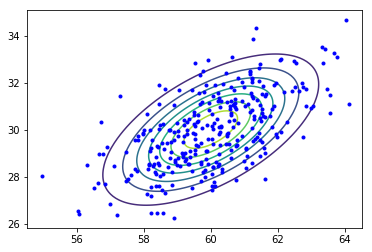

In [2]:
#First Attempt (For a fixed true Er)
#Parameters
stdQ = 1
stdP = 1
V = 1
eps = 1
Er = 30
F = 1/20
meanN = Er/eps
stdN = math.sqrt(F*meanN)

#Analytical Solution
ac = (((V/stdP)**2)+((eps/stdQ)**2)+((1/stdN)**2))/2

def bc(p0, q0):
    ans = (V*(Er-p0)/(stdP**2)-eps*q0/(stdQ**2)-meanN/(stdN**2))
    return ans

def cc(p0, q0):
    ans = ((((Er-p0)/stdP)**2)+((q0/stdQ)**2)+((meanN/stdN)**2))/2
    return ans

def fc(p0, q0):
    ans = np.exp(-cc(p0,q0)+(bc(p0,q0)**2)/(4*ac))/(2*math.pi*stdQ*stdP*stdN*math.sqrt(2*ac))
    return ans

#Sampling
k = 300

EPdata = []
EQdata = []

for k0 in range(k):
    N0 = np.random.normal(meanN,stdN,1)
    xP = np.random.normal(0,stdP,1)
    xQ = np.random.normal(0,stdQ,1)
    EP = Er + V*N0 + xP
    EQ = eps*N0 + xQ
    EPdata.append(EP)
    EQdata.append(EQ)
    
    
minP = min(EPdata)
minQ = min(EQdata)
maxP = max(EPdata)
maxQ = max(EQdata)
stepP = (maxP-minP)/100
stepQ = (maxQ-minQ)/100
p = np.arange(minP-5*stepP, maxP+5*stepP, stepP)
q = np.arange(minQ-5*stepQ, maxQ+5*stepQ, stepQ)
pp, qq = np.meshgrid(p, q, sparse=True)

z = fc(pp,qq)

#print(z)
#print(fc(p[0],q[0]),fc(p[1],q[0]),z[0][0],z[0][1])

#print(np.shape(z),np.shape(p),np.shape(q),np.shape(pp),np.shape(qq))
#print(pp[0,1])
print()

plt.plot(EPdata,EQdata,'b.')
plt.contour(p,q,z)
plt.show()

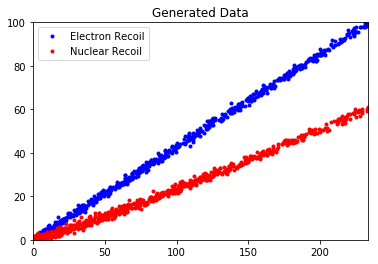

0.001271647043007024
0.0012848560437242705


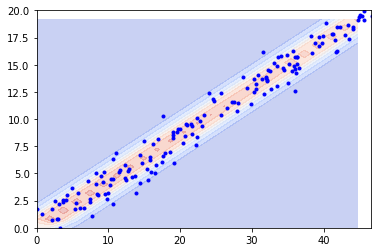

0.0012321794452513461


In [23]:
#Parameters
alphaP = 1
betaP  = 0
gammaP = 0
alphaQ = 1
betaQ  = 0
gammaQ = 0
eps    = .003
V      = .004
F      = .3
lam    = 100 #in keV
a      = .16
b      = .18


#Sample Size
J = 1000

#Data Generation
EPdataE = []
EQdataE = []
EPdataN = []
EQdataN = []
ErdataE = []
ErdataN = []

for j in range(J):
    Er = np.random.exponential(lam,1)
    sigP = math.sqrt(alphaP+betaP*Er*(1+V/eps)+gammaP*((Er*(1+V/eps))**2))
    sigQ = math.sqrt(alphaQ+betaQ*Er+gammaQ*(Er**2))
    N = np.random.normal(Er/eps,math.sqrt(F*Er/eps),1)
    xP = np.random.normal(0,sigP,1)
    xQ = np.random.normal(0,sigQ,1)
    EP = Er + V*N + xP
    EQ = eps*N+xQ
    ErdataE.append(Er)
    EPdataE.append(EP)
    EQdataE.append(EQ)

for j in range(J):
    Er = np.random.exponential(lam,1)
    ErY = a*(Er**(b+1))
    sigP = math.sqrt(alphaP+betaP*(Er+V*ErY/eps)+gammaP*((Er+V*ErY/eps)**2))
    sigQ = math.sqrt(alphaQ+betaQ*ErY+gammaQ*(ErY**2))
    N = np.random.normal(ErY/eps,math.sqrt(F*ErY/eps),1)
    xP = np.random.normal(0,sigP,1)
    xQ = np.random.normal(0,sigQ,1)
    EP = Er + V*N + xP
    EQ = eps*N+xQ
    ErdataN.append(Er)
    EPdataN.append(EP)
    EQdataN.append(EQ)
"""
density = True
bins = 100
exphist, bin_edges = np.histogram(ErdataN, bins, density=density)  

plt.plot(bin_edges[0:-1],exphist, drawstyle = "steps-mid", color="red")
plt.show()
"""

#Pseudo-Analytic Solution #1    
def fv(p0, q0, x0):
    stdP = np.sqrt(alphaP+betaP*x0+gammaP*(x0**2))
    stdQ = np.sqrt(alphaQ+betaQ*x0+gammaQ*(x0**2))
    stdN = np.sqrt(F*x0/eps)
    meanN = x0/eps
    av = (((V/stdP)**2)+((eps/stdQ)**2)+((1/stdN)**2))/2
    bv = (V*(x0-p0)/(stdP**2)-eps*q0/(stdQ**2)-meanN/(stdN**2))
    cv = ((((x0-p0)/stdP)**2)+((q0/stdQ)**2)+((meanN/stdN)**2))/2
    f_pq_r = np.exp((bv**2)/(4*av)-cv)/(2*math.pi*stdQ*stdP*stdN*math.sqrt(2*av))
    f_r = np.exp(-x0/lam)/lam
    ans = f_pq_r*f_r
    #print(stdP,stdQ,stdN,av,bv,cv,(bv**2)/(4*av)-cv,ans)
    return ans

f = lambda x0, p0, q0: fv(p0,q0,x0)
f_vec = np.vectorize(f)

def Fv0(p0,q0):
    ans = integrate.quad(f, 0, np.inf, args = (p0,q0,))[0]
    return ans

def Fv(p0,q0):
    sigP = math.sqrt(alphaP+betaP*(p0-(V*q0/eps))+gammaP*((p0-(V*q0/eps))**2))
    sigQ = math.sqrt(alphaQ+betaQ*(p0-(V*q0/eps))+gammaQ*((p0-(V*q0/eps))**2))
    L = ((V/(sigP**2))**2)/(2*(((V/sigP)**2)+((eps/sigQ)**2)))
    delt = -((sigP**2)/V)*((eps*q0)/(sigQ**2)+(1/F)+(V*p0)/(sigP**2))
    H = eps/(F*(((V/sigP)**2)+((eps/sigQ)**2)))
    a0 = -1/(2*sigP)+L
    b0 = p0/(sigP**2)-1/(2*F*eps)-1/lam+L*(2*delt-H)
    d0 = -L*H*((delt-H)**2)
    cubCoeff = [2*a0,(b0+4*a0*H),2*H*(b0+a0*H),b0*H*H-d0]
    solns = np.roots(cubCoeff)
    Rsolns = []
    for sol in solns:
        if np.isreal(sol):
            Rsolns.append(sol)
    loc = np.max(Rsolns)
    W0 = (a0+d0/((loc+H)**3))
    sca = np.sqrt(-1/(2*W0))
    NoDevs = 5
    minx = np.max([(loc-NoDevs*sca),0])
    maxx = np.max([(loc+NoDevs*sca),0])
    ans = integrate.quad(f, minx, maxx, args = (p0,q0,))[0]
    #ranlist = np.arange(minx,maxx,(maxx-minx)/50)
    #print(ranlist)
    #plt.plot(ranlist,f_vec(ranlist,p0,q0))
    #plt.title("(Ep = " + str(p0) + ", Eq = " + str(q0) + ")")
    #plt.show()
    return ans

Fv0_vec = np.vectorize(Fv0)
Fv_vec = np.vectorize(Fv)

#Graphing (Electron vs Nuclear Generated Data)
xE = EPdataE
yE = EQdataE
xN = EPdataN
yN = EQdataN

plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.plot(xN,yN,'r.', label = "Nuclear Recoil")
plt.ylim(0,100)
plt.xlim(0,100*(1+V/eps))
plt.title("Generated Data")
plt.legend()
plt.show()

#Graphing (Electron Recoil, Pseudo-Analytic vs Data Generation)
minP = 0  #min(xE)
minQ = 0  #min(yE)
maxP = 20*(1+V/eps)  #max(xE)
maxQ = 20  #max(yE)
stepNo = 25
stepP = (maxP-minP)/stepNo
stepQ = (maxQ-minQ)/stepNo
p1 = np.arange(minP, maxP, stepP)
q1 = np.arange(minQ, maxQ, stepQ)
pp1, qq1 = np.meshgrid(p1, q1, sparse=True)

zz = [[0 for x in range(len(q1))] for y in range(len(p1))]

count1 = 0
for ppp1 in p1:
    count2 = 0
    for qqq1 in q1:
        zz[count1][count2] = Fv(ppp1,qqq1)
        count2+=1
    count1+=1

#print(zz)
ErTest = 20
EpTest = ErTest*(1 + (V/eps))
EqTest = ErTest

print(fv(EpTest,EqTest,ErTest))
print(Fv(EpTest,EqTest))

#plt.plot(xE,yE,'b.')
plt.contourf(p1,q1,zz, cmap='coolwarm',alpha=.3)
plt.plot(xE,yE,'b.', label = "Electron Recoil")
plt.ylim(0,20)
plt.xlim(0,20*(1+V/eps))
plt.show()

print(Fv(1,1))